### **Load Libraies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Pillow
!pip install Keras-Preprocessing
!pip install ktrain

In [ ]:
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.corpus import reuters
from nltk.corpus import brown
from nltk.corpus import gutenberg
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

import seaborn as sns
import plotly.express as px
import pickle
import joblib
from collections import Counter
from textblob import Word
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
import re
import ktrain
from ktrain import text
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences

sns.set()
%matplotlib inline

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('gutenberg')
nltk.download('brown')
nltk.download("reuters")
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
# Numpy & matplotlib for notebooks
%pylab inline

# Pandas for data analysis and manipulation
import pandas as pd
from xgboost import XGBRegressor
# Sklearn
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron classifier which optimizes the log-loss function using LBFGS or sdg.
from sklearn.model_selection import train_test_split # to split arrays or matrices into random train and test subsets
from sklearn.model_selection import KFold # K-Folds cross-validator providing train/test indices to split data in train/test sets.
from sklearn.decomposition import PCA, TruncatedSVD # Principal component analysis (PCA); dimensionality reduction using truncated SVD.
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts
from sklearn.metrics import roc_auc_score as roc # Compute Area Under the Receiver Operating Characteristic Curve from prediction scores
from sklearn.metrics import roc_curve, auc # Compute ROC; Compute Area Under the Curve (AUC) using the trapezoidal rule
from sklearn.model_selection import cross_val_score

# Matplotlib
import matplotlib # Data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Seaborn
import seaborn as sns # Statistical data visualization (based on matplotlib)

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Populating the interactive namespace from numpy and matplotlib


In [ ]:
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
# Joblib
import joblib # To save models

In [ ]:
datafolder='/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/Data/'
modelfolder='/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/Model/'
arrayfolder='/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/NumPyArrays/'

### **Data Preparion**

In [ ]:
train_data = pd.read_csv(datafolder+'df_category_Emotion_unique1.csv')
train_data.drop(['Unnamed: 0'],
  axis='columns', inplace=True)
train_data['CONTENT']=train_data['CONTENT'].fillna("")
train_data.isna().sum()

CONTENT           0
CATEGORY_CLASS    0
dtype: int64

In [ ]:
train_data.head()

,CONTENT,CATEGORY_CLASS
0,i dont like that it makes mike mad because i f...,ANGER
1,im still unstable but im feeling very sarcasti...,ANGER
2,i feel incredibly greedy whenever i take so mu...,ANGER
3,i have been in bitchy mood the more i think th...,ANGER
4,i feel angry that the police is not being supp...,ANGER


In [ ]:
train_data.shape

(296203, 2)

In [ ]:
X = []
# the genders
y = []
# lengths of X elements
X_len = []
for index, row in train_data.iterrows():
    X.append(row["CONTENT"])
    X_len.append([len(row["CONTENT"])])
    y.append(row["CATEGORY_CLASS"])

In [ ]:
joblib.dump(X_len, arrayfolder+'X_len_emotion_Classification.pkl')
joblib.dump(y, arrayfolder+'y_emotion_Classification.pkl')

['/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/NumPyArrays/y_emotion_Classification.pkl']

#### **Help Methods & Data Cleaning**

In [ ]:
# preprocessing functions
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)

# remove words that end with one or more identical letters
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

def remove_allcaps(text):
    caps = re.compile(r'([^a-z0-9()<>\'`\-]){2,}')
    return caps.sub(r'ALLCAPS', text)

def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    return smiley.sub(r'SMILE', text)

def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# tags Part of Speech (POS), because teh lemmatizer needs it
tag_map = defaultdict(lambda : wn.NOUN)
# wn does a grammatical analysis
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
# create lemmatizer
word_Lemmatized = WordNetLemmatizer()

def review_to_words(raw_body):
    # remove html tags
    body_text = BeautifulSoup(raw_body).get_text()
    #letters_only = re.sub("[^a-zA-Z]", " ", body_text)
    # lowercase all text
    words = body_text.lower()
    # remove urls
    text = remove_URL(words)
    # remove numbers
    text = remove_number(text)
    # remove smiles
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    text = remove_elongated_words(text)
    words = remove_repeat_punct(text)
    # tokenizes and pass to lemmatizer, which lemmatizes taking tags into account (see before)
    words = word_tokenize(words)
    # we don't remove stop words, because doing it on combination with removing the 40 (trial & error estimated parameter) most utilized words (see below) decreases performance
    #stops = set(stopwords.words("english"))
    #meaningful_words = [w for w in words if not w in stops]
    Final_words = []
    for word, tag in pos_tag(words):
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # returns lemmatized texts as strings
    return( " ".join(Final_words))

In [ ]:
clean_train_comments = [review_to_words(x) for x in X]

<ipython-input-17-1e68d722f9d6>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  body_text = BeautifulSoup(raw_body).get_text()


In [ ]:
type(clean_train_comments)

list

In [ ]:
tokens = word_tokenize(" ".join(clean_train_comments))
type(tokens)

list

In [ ]:
#How many unique words?
unique = set(tokens)
print("No. of unique tokens: ", len(unique))
print("Average frequency of tokens: ", len(tokens)/len(unique))
sorted(unique)[:30]

In [ ]:
# Any single character words?
single=[w for w in unique if len(w) == 1 ]
print("No. of single character tokens: ", len(single))
single

In [ ]:
fd = nltk.FreqDist(tokens)
print(fd.most_common(50))
fd.plot(50)

In [ ]:
# More explorations: how long are the words?
fd_wlen = nltk.FreqDist([len(w) for w in unique])
sorted(fd_wlen.items())

In [ ]:
# Now let's perform text preprocessing:
# remove punctuations
import string
tokens_nop = [ t for t in tokens if t not in string.punctuation ]
print("Before punctuation removal: ", tokens[:50])
print("After punctuation removal: ", tokens_nop[:50])
print("No. of tokens (before punc removal): ", len(tokens))
print("No. of tokens (after punc removal): ", len(tokens_nop))
print("No. of unique tokens after punc removal: ", len(set(tokens_nop)))

Before punctuation removal:  ['i', 'dont', 'like', 'that', 'it', 'make', 'mike', 'mad', 'because', 'i', 'feel', 'a', 'though', 'be', 'suppose', 'to', 'sympathize', 'with', 'the', 'main', 'character', 'and', 'im', 'not', 'mad', 'at', 'sam', 'im', 'still', 'unstable', 'but', 'im', 'feeling', 'very', 'sarcastic', 'and', 'bitter', 'i', 'feel', 'incredibly', 'greedy', 'whenever', 'i', 'take', 'so', 'much', 'a', 'a', 'bite', 'out']
After punctuation removal:  ['i', 'dont', 'like', 'that', 'it', 'make', 'mike', 'mad', 'because', 'i', 'feel', 'a', 'though', 'be', 'suppose', 'to', 'sympathize', 'with', 'the', 'main', 'character', 'and', 'im', 'not', 'mad', 'at', 'sam', 'im', 'still', 'unstable', 'but', 'im', 'feeling', 'very', 'sarcastic', 'and', 'bitter', 'i', 'feel', 'incredibly', 'greedy', 'whenever', 'i', 'take', 'so', 'much', 'a', 'a', 'bite', 'out']
No. of tokens (before punc removal):  5333711
No. of tokens (after punc removal):  5254710
No. of unique tokens after punc removal:  78071


In [ ]:
# Create a stopword list from the standard list of stopwords available in nltk
stop = stopwords.words('english')
print(stop)
len(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

179

In [ ]:
# Remove all these stopwords from the text
tokens_nostop=[ t for t in tokens_nop if t not in stop ]
tokens_nostop=[x for x in tokens_nostop if len(x)>2]
print(tokens_nostop[:50])
print("No. of tokens(before stopword removal): ", len(tokens_nop))
print("No. of tokens(after stopword removal): ", len(tokens_nostop))

['dont', 'like', 'make', 'mike', 'mad', 'feel', 'though', 'suppose', 'sympathize', 'main', 'character', 'mad', 'sam', 'still', 'unstable', 'feeling', 'sarcastic', 'bitter', 'feel', 'incredibly', 'greedy', 'whenever', 'take', 'much', 'bite', 'piece', 'food', 'problem', 'eat', 'front', 'people', 'bitchy', 'mood', 'think', 'feel', 'bitchy', 'feel', 'angry', 'police', 'supportive', 'case', 'mad', 'expose', 'feel', 'ive', 'piss', 'whole', 'world', 'feel', 'greedy']
No. of tokens(before stopword removal):  5254710
No. of tokens(after stopword removal):  2610849


In [ ]:
# And remove the numbers
tokens_nonum = [ t for t in tokens_nostop if not t.isnumeric() ]
print("No. of tokens(after number removal): ", len(tokens_nonum))

No. of tokens(after number removal):  2610849


In [ ]:
# And remove the numbers
tokens_nonum = [ t for t in tokens_nostop if not t.isnumeric() ]
print("No. of tokens(after number removal): ", len(tokens_nonum))

No. of tokens(after number removal):  2610849


In [ ]:
from nltk import word_tokenize, FreqDist
filter_list = [ "’", "“", "”","would", "could",'im','a','o' ]
tokens_clean = [ t for t in tokens_nonum if t not in filter_list ]
FreqDist(tokens_clean).most_common(50)

In [ ]:
# Now, let's do some Stemming!
# There are different stemmers available in Python. Let's take a look at a few

# The most popular stemmer
porter = nltk.PorterStemmer()
tokens_porter=[ porter.stem(t) for t in tokens_clean ]
#print("Before stemming: ", tokens_clean[:30])
#print("After stemming(Porter): ", tokens_porter[:30])
for t0, t1 in zip(tokens_clean[:20], tokens_porter[:20]):
    print("{:15s}{:15s}".format(t0, t1))

In [ ]:
fd = nltk.FreqDist(tokens_porter)
print(fd.most_common(50))
fd.plot(50)

In [ ]:
# Any single character words?
single=[w for w in tokens_porter if len(w) == 1 ]
print("No. of single character tokens: ", len(single))
single

No. of single character tokens:  6


['a', 'o', 'a', 'a', 'a', 'a']

In [ ]:
# tags Part of Speech (POS), because teh lemmatizer needs it
tag_map = defaultdict(lambda : wn.NOUN)
# wn does a grammatical analysis
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
# create lemmatizer
word_Lemmatized = WordNetLemmatizer()
import string
def review_to_words(raw_body):
    # remove html tags
    body_text = BeautifulSoup(raw_body).get_text()
    #letters_only = re.sub("[^a-zA-Z]", " ", body_text)
    # lowercase all text
    words = body_text.lower()
    # remove urls
    text = remove_URL(words)
    # remove numbers
    text = remove_number(text)
    # remove smiles
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    text = remove_elongated_words(text)
    words = remove_repeat_punct(text)

    # tokenizes and pass to lemmatizer, which lemmatizes taking tags into account (see before)
    words = word_tokenize(words)
    #words1=[x for x in words if len(x)>2]

    # we don't remove stop words, because doing it on combination with removing the 40 (trial & error estimated parameter) most utilized words (see below) decreases performance
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    filter_list = [ "’", "“", "”","'","would", "could",'im','a','o' ,'and','at','em']
    tokens_clean = [ t for t in meaningful_words if t not in filter_list ]
    tokens_nop = [ t for t in tokens_clean if t not in string.punctuation ]
    porter = nltk.PorterStemmer()
    tokens_porter=[ porter.stem(t) for t in tokens_nop ]
    words1=[x for x in tokens_porter if len(x)>2]

    Final_words = []
    for word, tag in pos_tag(words1):
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # returns lemmatized texts as strings
    return( " ".join(Final_words))

In [ ]:
clean_train_comments2 = [review_to_words(x) for x in X]

<ipython-input-61-42a99fb98b5c>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  body_text = BeautifulSoup(raw_body).get_text()


In [ ]:
clean_train_comments2

In [ ]:
tokens2 = word_tokenize(" ".join(clean_train_comments2))
type(tokens2)

list

In [ ]:
tokens2[:200]

In [ ]:
#How many unique words?
unique2 = set(tokens2)
print("No. of unique tokens: ", len(unique))
print("Average frequency of tokens: ", len(tokens2)/len(unique2))
#sorted(unique2)[:100]

No. of unique tokens:  78102
Average frequency of tokens:  39.72533345584294


In [ ]:
joblib.dump(clean_train_comments2, arrayfolder+'clean_train_comments2_Category_Classification_MLP.pkl')

['/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/NumPyArrays/clean_train_comments2_Category_Classification_MLP.pkl']

### **Build training pipeline ML**

In [ ]:
y=joblib.load(arrayfolder+'y_emotion_Classification.pkl')
clean_train_comments2=joblib.load(arrayfolder+'clean_train_comments2_Category_Classification_MLP.pkl')
#####################Data Split and Create DTM
#split the data into training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(clean_train_comments2, y, test_size=0.10, random_state=12,stratify = y)

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
np.array(X_train).shape,np.array(X_test).shape,np.array(y_train).shape,np.array(y_test).shape

((266582,), (29621,), (266582,), (29621,))

#### **Build training pipeline using  Naïve Bayes Model**

In [ ]:
#####################Build training pipeline using  Naïve Bayes Model
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
##Evaluate the model
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
text_clf_Pipeline1 = Pipeline([('vect', CountVectorizer(analyzer = "word",min_df = 2, max_df=0.7,max_features = 5000)), #Vectorizer
                     ('tfidf', TfidfTransformer(norm='l2',sublinear_tf=True)), #DTM with TFIDF
                      ('clf', MultinomialNB()), #ML Model
                    ])

text_clf_Pipeline1.fit(X_train,y_train )

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.7, max_features=5000, min_df=2)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf', MultinomialNB())])

NB: 0.7751595152088046


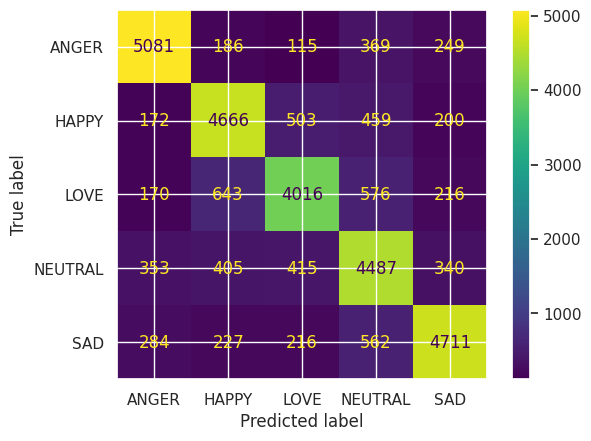

In [ ]:
predicted = text_clf_Pipeline1.predict(X_test)
#print(metrics.confusion_matrix(y_test, predicted))
print("NB:",np.mean(predicted == y_test) )

cm = confusion_matrix(y_test, predicted, labels=text_clf_Pipeline1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=text_clf_Pipeline1.classes_)
disp.plot()
plt.show()

In [ ]:
########################Prediction on new documents
docs_new = ['Crude price is dropping ', 'interest rate is increasing']
predicted = text_clf_Pipeline1.predict(docs_new)
print(predicted)

['HAPPY' 'HAPPY']


#### **Build training pipeline using  Decision Tree Model**

In [ ]:
#####################Build training pipeline using  Decision Tree Model
from sklearn import tree
text_clf_Pipeline2 = Pipeline([('vect', CountVectorizer(analyzer = "word",min_df = 2, max_df=0.7,max_features = 5000)), #Vectorizer
                     ('tfidf', TfidfTransformer(norm='l2',sublinear_tf=True)), #DTM with TFIDF
                      ('clf', tree.DecisionTreeClassifier())
                    ])
text_clf_Pipeline2.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.7, max_features=5000, min_df=2)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf', DecisionTreeClassifier())])

DT: 0.7712433746328619


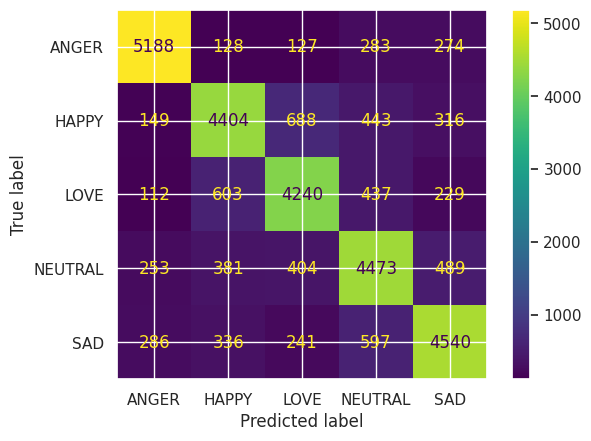

In [ ]:
predicted = text_clf_Pipeline2.predict(X_test)
#print(metrics.confusion_matrix(y_test, predicted))
print("DT:",np.mean(predicted == y_test) )
cm = confusion_matrix(y_test, predicted, labels=text_clf_Pipeline2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=text_clf_Pipeline2.classes_)
disp.plot()
plt.show()

In [ ]:
########################Prediction on new documents
docs_new = ['Crude price is dropping ', 'interest rate is increasing']
predicted = text_clf_Pipeline2.predict(docs_new)
print(predicted)

['NEUTRAL' 'HAPPY']


#### **Build training pipeline using  SVM Model**

In [ ]:
#####################Build training pipeline using  SVM Model
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
text_clf_Pipeline3 = Pipeline([('vect', CountVectorizer(analyzer = "word",min_df = 2, max_df=0.7,max_features = 4000)), #Vectorizer
                     ('tfidf', TfidfTransformer(norm='l2',sublinear_tf=True)), #DTM with TFIDF
                      ('clf', svm.LinearSVC(C=1.0))
                    ])
text_clf_Pipeline3.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.7, max_features=4000, min_df=2)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf', LinearSVC())])

SVM: 0.8099659025691233


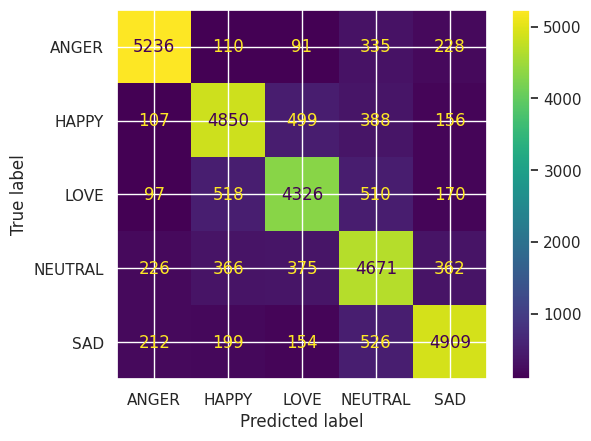

In [ ]:
predicted = text_clf_Pipeline3.predict(X_test)
#print(metrics.confusion_matrix(y_test, predicted))
print("SVM:",np.mean(predicted == y_test) )
cm = confusion_matrix(y_test, predicted, labels=text_clf_Pipeline3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=text_clf_Pipeline3.classes_)
disp.plot()
plt.show()

In [ ]:
########################Prediction on new documents
docs_new = ['Crude price is dropping ', 'interest rate is increasing']
predicted = text_clf_Pipeline3.predict(docs_new)
print(predicted)

['NEUTRAL' 'NEUTRAL']


#### **Build training pipeline using  RandomForestClassifier Model**

In [ ]:
#####################Build training pipeline using  RandomForestClassifier Model
text_clf_Pipeline4 = Pipeline([('vect', CountVectorizer(analyzer = "word",min_df = 2, max_df=0.7,max_features = 4000)), #Vectorizer
                     ('tfidf', TfidfTransformer(norm='l2',sublinear_tf=True)), #DTM with TFIDF
                      ('rf', RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, class_weight='balanced'))
                    ])
text_clf_Pipeline4.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.7, max_features=4000, min_df=2)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        n_estimators=300, random_state=42))])

RF: 0.6980182978292427


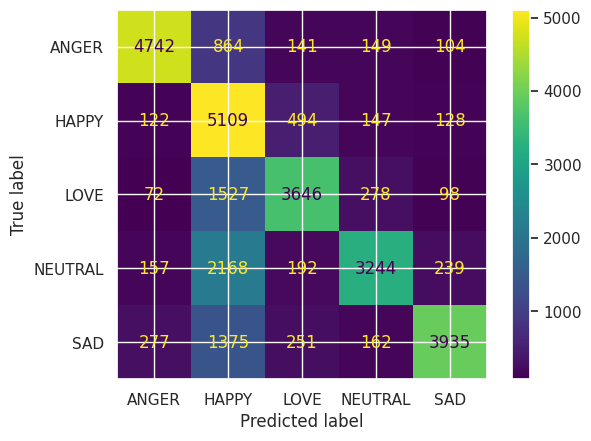

In [ ]:
predicted = text_clf_Pipeline4.predict(X_test)
#print(metrics.confusion_matrix(y_test, predicted))
print("RF:",np.mean(predicted == y_test) )
cm = confusion_matrix(y_test, predicted, labels=text_clf_Pipeline4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=text_clf_Pipeline4.classes_)
disp.plot()
plt.show()

In [ ]:
########################Prediction on new documents
docs_new = ['Crude price is dropping ', 'interest rate is increasing']
predicted = text_clf_Pipeline4.predict(docs_new)
print(predicted)

['HAPPY' 'HAPPY']


#### **Build training pipeline using  LogisticRegression Model**

In [ ]:
#####################Build training pipeline using  LogisticRegression Model
text_clf_Pipeline5 = Pipeline([('vect', CountVectorizer(analyzer = "word",min_df = 2, max_df=0.7,max_features = 4000)), #Vectorizer
                     ('tfidf', TfidfTransformer(norm='l2',sublinear_tf=True)), #DTM with TFIDF
                      ('lr', LogisticRegression(C = 3, max_iter = 1000, n_jobs=-1,multi_class='multinomial'))
                    ])
text_clf_Pipeline5.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.7, max_features=4000, min_df=2)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('lr',
                 LogisticRegression(C=3, max_iter=1000,
                                    multi_class='multinomial', n_jobs=-1))])

LR: 0.8090881469227913


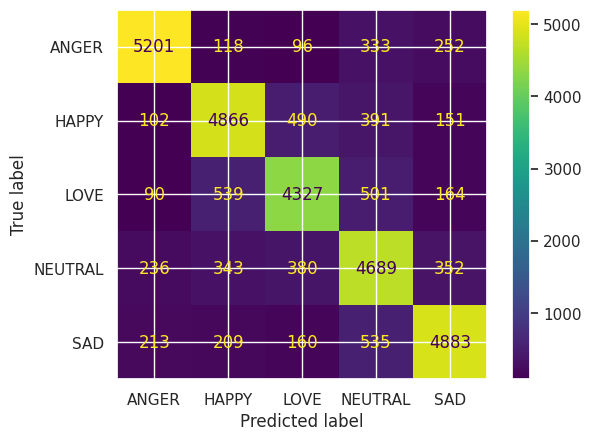

In [ ]:
predicted = text_clf_Pipeline5.predict(X_test)
#print(metrics.confusion_matrix(y_test, predicted))
print("LR:",np.mean(predicted == y_test) )
cm = confusion_matrix(y_test, predicted, labels=text_clf_Pipeline5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=text_clf_Pipeline5.classes_)
disp.plot()
plt.show()

In [ ]:
########################Prediction on new documents
docs_new = ['Crude price is dropping ', 'interest rate is increasing']
predicted = text_clf_Pipeline5.predict(docs_new)
print(predicted)

['NEUTRAL' 'NEUTRAL']


#### **Build training pipeline using  MLPClassifier**

In [ ]:
#####################Build training pipeline using  MLPClassifier
text_clf_Pipeline6 = Pipeline([('vect', CountVectorizer(analyzer = "word",min_df = 2, max_df=0.7,max_features = 4000)), #Vectorizer
                     ('tfidf', TfidfTransformer(norm='l2',sublinear_tf=True)), #DTM with TFIDF
                      ('mlp', MLPClassifier(activation= 'relu', solver = 'adam',alpha = 0.05, learning_rate = 'invscaling', verbose = True,early_stopping = True, max_iter = 400, random_state=0))
                    ])
text_clf_Pipeline6.fit(X_train, y_train)

Iteration 1, loss = 0.81029938
Validation score: 0.802768
Iteration 2, loss = 0.66223636
Validation score: 0.805432
Iteration 3, loss = 0.64906654
Validation score: 0.804119
Iteration 4, loss = 0.64111809
Validation score: 0.805432
Iteration 5, loss = 0.63545972
Validation score: 0.807157
Iteration 6, loss = 0.63205390
Validation score: 0.805019
Iteration 7, loss = 0.62918220
Validation score: 0.807382
Iteration 8, loss = 0.62680095
Validation score: 0.807120
Iteration 9, loss = 0.62544794
Validation score: 0.808170
Iteration 10, loss = 0.62396743
Validation score: 0.811133
Iteration 11, loss = 0.62261767
Validation score: 0.809783
Iteration 12, loss = 0.62143571
Validation score: 0.810083
Iteration 13, loss = 0.62036760
Validation score: 0.808620
Iteration 14, loss = 0.61908963
Validation score: 0.810270
Iteration 15, loss = 0.61836915
Validation score: 0.811996
Iteration 16, loss = 0.61685485
Validation score: 0.811658
Iteration 17, loss = 0.61638332
Validation score: 0.810533
Iterat

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.7, max_features=4000, min_df=2)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('mlp',
                 MLPClassifier(alpha=0.05, early_stopping=True,
                               learning_rate='invscaling', max_iter=400,
                               random_state=0, verbose=True))])

LR: 0.8150298774518079


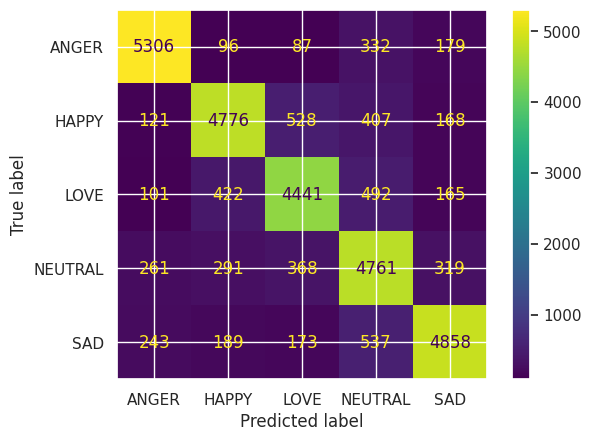

In [ ]:
predicted = text_clf_Pipeline6.predict(X_test)
#print(metrics.confusion_matrix(y_test, predicted))
print("LR:",np.mean(predicted == y_test) )
cm = confusion_matrix(y_test, predicted, labels=text_clf_Pipeline6.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=text_clf_Pipeline6.classes_)
disp.plot()
plt.show()

In [ ]:
########################Prediction on new documents
docs_new = ['Crude price is dropping ', 'interest rate is increasing']
predicted = text_clf_Pipeline6.predict(docs_new)
print(predicted)

['NEUTRAL' 'NEUTRAL']


### **CountVectorizer**

In [ ]:
clean_train_comments2=joblib.load(arrayfolder+'clean_train_comments2_Category_Classification_MLP.pkl')

In [ ]:
X_len=joblib.load(arrayfolder+'X_len_emotion_Classification.pkl')
y=joblib.load(arrayfolder+'y_emotion_Classification.pkl')

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer # Il CountVectorizer ha performato meglio
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word",min_df = 2, max_df=0.7,
                             max_features = 2000)
# converts in np array
train_data_features = vectorizer.fit_transform(clean_train_comments2).toarray()


print(train_data_features.shape)
# print vocabulary
vocab = vectorizer.get_feature_names_out()
#print(vocab)
import numpy as np

# counts how many times a word appearco
dist = np.sum(train_data_features, axis=0)

##for tag, count in zip(vocab, dist):
    ##print(count, tag)

    # removes the 40 most utilized words
#for _ in range(40):
    #index = np.argmax(dist)
    #train_data_features = np.delete(train_data_features, index, axis = 1)

train_data_features.shape

# np array
s = np.concatenate((train_data_features,np.array(X_len)),axis = 1)

# 5000 rows (one per author),  and 2000-40+1 (X_len) features
print(s.shape)

# un np.array
y = np.array(y)

(296203, 2000)
(296203, 2001)


In [ ]:
joblib.dump(vectorizer, arrayfolder+'vectorizer_emotion.pkl')
joblib.dump(vocab, arrayfolder+'vocab_2000_emotion.pkl')

['/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/NumPyArrays/vocab_2000_emotion.pkl']

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical,plot_model
le=LabelEncoder()
lbls=le.fit_transform(y)
classes=list(le.classes_)
classes=[str(c) for c in classes]
lbls=to_categorical(lbls,num_classes=len(classes))
classes

['ANGER', 'HAPPY', 'LOVE', 'NEUTRAL', 'SAD']

In [ ]:
joblib.dump(classes, arrayfolder+'classes_emotion.pkl')

['/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/NumPyArrays/classes_emotion.pkl']

In [ ]:
joblib.dump(lbls, arrayfolder+'lbls_emotion.pkl')
joblib.dump(s, arrayfolder+'s_10000_emotion.pkl')

['/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/NumPyArrays/s_10000_emotion.pkl']

In [ ]:
classes

['ANGER', 'HAPPY', 'LOVE', 'NEUTRAL', 'SAD']

### **Preparation**

In [ ]:
lbls=joblib.load(arrayfolder+'lbls_emotion.pkl')
s=joblib.load(arrayfolder+'s_10000_emotion.pkl')

In [ ]:
s.shape

(296203, 2001)

In [ ]:
# Split the data for training
X1, X_valid, Y1, y_valid = train_test_split(s, lbls,
                                                      train_size=0.6, test_size=0.1,
                                                      random_state=0,stratify = lbls)
X1.shape,X_valid.shape,Y1.shape,y_valid.shape

((177721, 2001), (29621, 2001), (177721, 5), (29621, 5))

In [ ]:
y_new=[]
for rowv in Y1:
  if rowv[0] ==1:
    y_new.append(1)
  if rowv[1] ==1:
    y_new.append(2)
  if rowv[2] ==1:
    y_new.append(3)
  if rowv[3] ==1:
    y_new.append(4)
  if rowv[4] ==1:
    y_new.append(5)
y_valid_new=[]
for rowv in y_valid:
  if rowv[0] ==1:
    y_valid_new.append(1)
  if rowv[1] ==1:
    y_valid_new.append(2)
  if rowv[2] ==1:
    y_valid_new.append(3)
  if rowv[3] ==1:
    y_valid_new.append(4)
  if rowv[4] ==1:
    y_valid_new.append(5)

y_new=np.array(y_new)
y_valid_new=np.array(y_valid_new)
y_new.shape,y_valid_new.shape

((177721,), (29621,))

### **MLP Classifier**

In [ ]:
# Define MLP Classifier:
## Activation function for the hidden layer: "rectified linear unit function"
## Solver for weight optimization: "stochastic gradient-based optimizer"
## Alpha: regularization parameter
## Learning rate schedule for weight updates: "gradually decreases the learning rate at each time step t using an inverse scaling exponent of power_t"
## Verbose: "True" in order to print progress messages to stdout.
## Early stopping: "True" in order to use early stopping to terminate training when validation score is not improving. It automatically sets aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.

mlpClf = MLPClassifier(activation= 'relu', solver = 'adam',
                       alpha = 0.05, learning_rate = 'invscaling', verbose = True,
                       early_stopping = True, max_iter = 400, random_state=0)

# Model fit
mlpClf.fit(X1, Y1)
joblib.dump(mlpClf, modelfolder+'mlpClf_emotion_2000.pkl')

Iteration 1, loss = 1.87778169
Validation score: 0.620604
Iteration 2, loss = 1.22915611
Validation score: 0.685028
Iteration 3, loss = 1.15871791
Validation score: 0.697856
Iteration 4, loss = 1.12181678
Validation score: 0.698363
Iteration 5, loss = 1.09448268
Validation score: 0.700838
Iteration 6, loss = 1.07168168
Validation score: 0.713498
Iteration 7, loss = 1.05735874
Validation score: 0.726383
Iteration 8, loss = 1.04445685
Validation score: 0.710516
Iteration 9, loss = 1.03244808
Validation score: 0.717380
Iteration 10, loss = 1.02313655
Validation score: 0.725089
Iteration 11, loss = 1.01591851
Validation score: 0.724020
Iteration 12, loss = 1.01005007
Validation score: 0.723626
Iteration 13, loss = 1.00370320
Validation score: 0.719912
Iteration 14, loss = 0.99864707
Validation score: 0.717887
Iteration 15, loss = 0.99140081
Validation score: 0.719518
Iteration 16, loss = 0.98944175
Validation score: 0.726664
Iteration 17, loss = 0.98656063
Validation score: 0.721431
Iterat

['/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/Model/mlpClf_emotion_2000.pkl']

In [ ]:
# Prediction
mlpClf=joblib.load(modelfolder+'mlpClf_emotion_2000.pkl')
y_score = mlpClf.predict(X_valid)
print("y_score.shape : ",y_score.shape),print("y_valid.shape : ",y_valid.shape)
roc_auc = roc(y_valid,y_score, multi_class='ovr')
print("roc_auc : ",roc_auc)

y_score.shape :  (29621, 5)
y_valid.shape :  (29621, 5)
roc_auc :  0.8679220294805792


### **LogisticRegression Classifier**

In [ ]:
lr = LogisticRegression(C = 3, max_iter = 1000, n_jobs=-1,multi_class='multinomial')
lr.fit(X1, y_new)
joblib.dump(lr, modelfolder+'LogisticRegression_Emotion_category_2000.pkl')

Accuracy: 0.8057796833327707
              precision    recall  f1-score   support

           1       0.89      0.86      0.88      6000
           2       0.79      0.79      0.79      6000
           3       0.80      0.76      0.78      5621
           4       0.71      0.79      0.75      6000
           5       0.85      0.82      0.83      6000

    accuracy                           0.81     29621
   macro avg       0.81      0.81      0.81     29621
weighted avg       0.81      0.81      0.81     29621



['/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/Model/LogisticRegression_Emotion_category_2000.pkl']

In [ ]:
lr=joblib.load(modelfolder+'LogisticRegression_Emotion_category_2000.pkl')
y_pred1 = lr.predict(X_valid)
print("Accuracy: "+str(accuracy_score(y_valid_new,y_pred1)))
print(classification_report(y_valid_new, y_pred1))

Accuracy: 0.8057796833327707
              precision    recall  f1-score   support

           1       0.89      0.86      0.88      6000
           2       0.79      0.79      0.79      6000
           3       0.80      0.76      0.78      5621
           4       0.71      0.79      0.75      6000
           5       0.85      0.82      0.83      6000

    accuracy                           0.81     29621
   macro avg       0.81      0.81      0.81     29621
weighted avg       0.81      0.81      0.81     29621



###  **Support Vector Machine**

In [ ]:
svc = LinearSVC()
svc.fit(X1, y_new)
joblib.dump(svc, modelfolder+'LinearSVC_Emotion_category_2000.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.7039262685257082
              precision    recall  f1-score   support

           1       0.92      0.73      0.81      6000
           2       0.71      0.80      0.75      6000
           3       0.88      0.52      0.65      5621
           4       0.83      0.53      0.65      6000
           5       0.51      0.93      0.66      6000

    accuracy                           0.70     29621
   macro avg       0.77      0.70      0.70     29621
weighted avg       0.77      0.70      0.71     29621



['/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/Model/LinearSVC_Emotion_category_2000.pkl']

In [ ]:
svc=joblib.load(modelfolder+'LinearSVC_Emotion_category_2000.pkl')
y_pred2 = svc.predict(X_valid)
print("Accuracy: "+str(accuracy_score(y_valid_new,y_pred2)))
print(classification_report(y_valid_new, y_pred2))

Accuracy: 0.7039262685257082
              precision    recall  f1-score   support

           1       0.92      0.73      0.81      6000
           2       0.71      0.80      0.75      6000
           3       0.88      0.52      0.65      5621
           4       0.83      0.53      0.65      6000
           5       0.51      0.93      0.66      6000

    accuracy                           0.70     29621
   macro avg       0.77      0.70      0.70     29621
weighted avg       0.77      0.70      0.71     29621



###  **Randomforest**

In [ ]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, class_weight='balanced')
rfc.fit(X1, y_new)
joblib.dump(rfc, modelfolder+'RandomForestClassifier_Emotion_category_2000.pkl')

Accuracy: 0.6709429121231558
              precision    recall  f1-score   support

           1       0.87      0.77      0.82      6000
           2       0.45      0.81      0.58      6000
           3       0.78      0.64      0.70      5621
           4       0.82      0.52      0.64      6000
           5       0.72      0.61      0.66      6000

    accuracy                           0.67     29621
   macro avg       0.73      0.67      0.68     29621
weighted avg       0.73      0.67      0.68     29621



['/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/Model/RandomForestClassifier_Emotion_category_2000.pkl']

In [ ]:
rfc=joblib.load(modelfolder+'RandomForestClassifier_Emotion_category_2000.pkl')
y_pred4 = rfc.predict(X_valid)
print("Accuracy: "+str(accuracy_score(y_valid_new,y_pred4)))
print(classification_report(y_valid_new, y_pred4))

Accuracy: 0.6709429121231558
              precision    recall  f1-score   support

           1       0.87      0.77      0.82      6000
           2       0.45      0.81      0.58      6000
           3       0.78      0.64      0.70      5621
           4       0.82      0.52      0.64      6000
           5       0.72      0.61      0.66      6000

    accuracy                           0.67     29621
   macro avg       0.73      0.67      0.68     29621
weighted avg       0.73      0.67      0.68     29621



### **XGBRegressor**

In [ ]:
my_model = XGBRegressor(n_estimators=10000, learning_rate=0.01, n_jobs=4,subsample = 0.9,
                       min_child_weight = 1,max_depth=4,gamma=1.5,colsample_bytree=0.6 )
my_model.fit(X1, y_new,
             early_stopping_rounds=90,
             #sample_weight = w,
             eval_set=[(X_valid, y_valid_new)],
             verbose=False)
joblib.dump(my_model, modelfolder+'XGBRegressorClassifier_Emotion_category_2000.pkl')

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


['/content/drive/MyDrive/Community Help /Text-Emotion-Analysis/Model/XGBRegressorClassifier_Emotion_category_2000.pkl']